In [1]:
import io
import json

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

import random
import matplotlib.pyplot as plt

**Lê os arquivos do dataset, contendo os pontos da face de cada imagem e probabilidade de olho aberto**

In [6]:
drowsy_data_file = open("./dataset_facesList_drowsy.json")
notdrowsy_data_file = open("./dataset_facesList_notdrowsy.json")

drowsy_dataset = json.load(drowsy_data_file)
notdrowsy_dataset = json.load(notdrowsy_data_file)

**Faz o pré-processamento dos dados, para utilizar o formato de entrada da rede proposta de 1x268. No final, é separado 70% dos dados para treinamento, e 30% para teste**

In [7]:
random.seed(1)

dataset_input = [*drowsy_dataset, *notdrowsy_dataset]
expected_output = [1 for _ in range(len(drowsy_dataset))] + [0 for _ in range(len(notdrowsy_dataset))]

complete_dataset = list(zip(dataset_input, expected_output))

random.shuffle(complete_dataset)
x_dataset, y_dataset = zip(*complete_dataset)

shuffled_x_data = list(x_dataset)
shuffled_y_data = list(y_dataset)

treated_shuffled_x_data = []

for x_entry in shuffled_x_data:
  points = x_entry['allPoints']
  random_angle = np.random.uniform(-15, 15)

  dx = random.uniform(10, 50)
  dy = random.uniform(10, 50)

  x_face_coord = [point['x'] + dx for point in points]
  y_face_coord = [point['y']  + dy for point in points]
  perclos_info = [x_entry['leftEyePerClos'], x_entry['rightEyePerClos']]

  treated_shuffled_x_data.append(np.array([*x_face_coord, *y_face_coord, *perclos_info]))

treated_shuffled_x_data = tf.reshape(treated_shuffled_x_data, (-1, 1, 268))
shuffled_y_data = tf.convert_to_tensor(shuffled_y_data, dtype=tf.float32)

x_train = treated_shuffled_x_data[:round(0.7*len(treated_shuffled_x_data))]
y_train = shuffled_y_data[:round(0.7*len(shuffled_y_data))]

x_test = treated_shuffled_x_data[round(0.7*len(treated_shuffled_x_data)) + 1:]
y_test = shuffled_y_data[round(0.7*len(shuffled_y_data)) + 1:]

**Configura Rede Neural Convolucional com os parâmetros**

In [8]:
model = models.Sequential()

model.add(layers.Reshape((268, 1), input_shape=(1, 268)))
model.add(layers.Conv1D(32, 3, activation='relu'))
model.add(layers.MaxPooling1D(2))
model.add(layers.Conv1D(64, 3, activation='relu'))
model.add(layers.MaxPooling1D(2))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))  # Camada de saída para classificação binária

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 268, 1)            0         
                                                                 
 conv1d (Conv1D)             (None, 266, 32)           128       
                                                                 
 max_pooling1d (MaxPooling1  (None, 133, 32)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 131, 64)           6208      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 65, 64)            0         
 g1D)                                                            
                                                                 
 flatten (Flatten)           (None, 4160)              0

In [9]:
history = model.fit(treated_shuffled_x_data, shuffled_y_data, epochs=10)

Epoch 1/10
63/63 [==============================] - 12s 6ms/step - loss: 8.5479 - accuracy: 0.6472
Epoch 2/10
63/63 [==============================] - 0s 5ms/step - loss: 0.5069 - accuracy: 0.7736
Epoch 3/10
63/63 [==============================] - 0s 5ms/step - loss: 0.4423 - accuracy: 0.8191
Epoch 4/10
63/63 [==============================] - 0s 5ms/step - loss: 0.4522 - accuracy: 0.8146
Epoch 5/10
63/63 [==============================] - 0s 5ms/step - loss: 0.3903 - accuracy: 0.8346
Epoch 6/10
63/63 [==============================] - 0s 5ms/step - loss: 0.2937 - accuracy: 0.9065
Epoch 7/10
63/63 [==============================] - 0s 5ms/step - loss: 0.2980 - accuracy: 0.8971
Epoch 8/10
63/63 [==============================] - 0s 5ms/step - loss: 0.2617 - accuracy: 0.9195
Epoch 9/10
63/63 [==============================] - 0s 5ms/step - loss: 0.2748 - accuracy: 0.9050
Epoch 10/10
63/63 [==============================] - 0s 4ms/step - loss: 0.2303 - accuracy: 0.9345


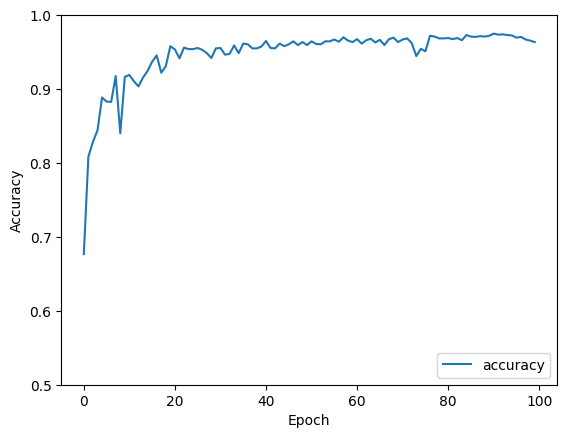

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [ ]:
test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)
print(test_acc)

19/19 - 0s - loss: 0.3491 - accuracy: 0.9032 - 250ms/epoch - 13ms/step
0.903171956539154


In [ ]:
tf.saved_model.save(model, 'saved_model')
converter = tf.lite.TFLiteConverter.from_saved_model('saved_model')  # Cria um conversor
tflite_model = converter.convert()  # Converte o modelo

with open('model.tflite', 'wb') as f:
    f.write(tflite_model)
